# 2005 UD Polarimetric Phase Curve Fitting

The dataset is composed of two components:

1. MSI data obtained in this work.
2. The data from [Devogele](https://ui.adsabs.harvard.edu/abs/2020PSJ.....1...15D/abstract), revised by Jooyeon Geem after retrieving the original FITS data (2021 Jan-Mar). Also the data at the largest phase angle (α=106.47˚) is analyzed.

As a part of the publication of IshiguroM+ 2019 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.4.1, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2021-03-18 20:32:59 (KST = GMT+0900) 
0 Python     3.8.8 64bit [Clang 10.0.0 ]
1 IPython    7.21.0
2 OS         macOS 10.16 x86_64 i386 64bit
3 scipy      1.6.1
4 numpy      1.19.2
5 matplotlib 3.3.4
6 pandas     1.2.3
7 numba      0.53.0
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


**NOTE**: For the parameter correlations plot, I used [``corner``](https://github.com/dfm/corner.py) package.

## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [2]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'     

In [3]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos
import theano
import corner

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import ysvisutilpy2005ud as yvu

from scipy.optimize import curve_fit
from scipy.stats import chi2

np.random.seed(12345)
plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')

### 3-2. Define
Define some things:

In [4]:
D2R = np.pi / 180
DATAPATH = Path('data')
SAVEPATH = Path('figs')

@nb.njit#(parallel=True)
def cos_deg(x):
    return np.cos(x * D2R)


@nb.njit#(parallel=True)
def sin_deg(x):
    return np.sin(x * D2R)


def trigp_purepython(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in pure python mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr

@nb.njit#(parallel=True)
def trigp(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in numba mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr


@nb.njit(parallel=True)
def do_trigp(x, y, yerr, arr_h, arr_c1, arr_c2, arr_a0, arr_chi2, arr_amax,
             arr_Pmax, arr_amin, arr_Pmin):
    ''' To calculate everything needed for the analysis.
    Parameters
    ----------
    x, y, yerr : array-like
        The phase angle [˚], Pr [%], and dPr [%].
    arr_h, arr_c1, arr_c2, arr_a0 : array-like
        The ``trace``d arrays of the four parameters of Lumme-Muinonen function
        from pymc3.
    arr_chi2, arr_amax, arr_Pmax, arr_amin, arr_Pmin : array-like
        The empty arrays of chi-square, min/max phase angle (``a``)
        and the polarization degree (``P``). Must have the same length as
        the arrays given above. (It will not give error if these are longer
        than the above ones, but...)
    '''
    xx_min = np.arange(2, 15, 0.01)
    xx_max = np.arange(80, 140, 0.01)

    for i in nb.prange(arr_h.shape[0]):
        h = arr_h[i]
        c1 = arr_c1[i]
        c2 = arr_c2[i]
        a0 = arr_a0[i]
        resid = y - trigp(x, h=h, c1=c1, c2=c2, a0=a0)
        chi2 = np.sum((resid / yerr)**2)
        amax, Pmax = trigp_max(xx_max, h=h, c1=c1, c2=c2, a0=a0)
        amin, Pmin = trigp_min(xx_min, h=h, c1=c1, c2=c2, a0=a0)

        arr_chi2[i] = chi2
        arr_amax[i] = amax
        arr_Pmax[i] = Pmax
        arr_amin[i] = amin
        arr_Pmin[i] = Pmin


@nb.njit#(parallel=True)
def trigp_min(xx, h, c1, c2, a0):
    """ Calculates the minimum phase angle/P degree from given parameters.
    """
    minimum = 1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p < minimum:
            minimum = p
        else:
            break
    return (xx[i - 1], minimum)


@nb.njit#(parallel=True)
def trigp_max(xx, h, c1, c2, a0):
    """ Calculates the maximum phase angle/P degree from given parameters.
    """
    maximum = -1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p > maximum:
            maximum = p
        else:
            break
    return (xx[i - 1], maximum)

### 3-3. Data
Now, load data and see if loaded correctly:

In [5]:
dats = pd.read_csv(DATAPATH/"pol_ud_data.csv", sep=',')
dats.insert(loc=7, column="dPr", value=dats["dP"])
dats = dats[dats["dPr"] < 10]
dats = dats.reset_index(drop=True)
dats

date  alpha      P    dP  theta_P  dtheta_P     Pr   dPr  theta_r  \
0   2018 Sep 24  68.10  23.34  3.58    12.10      4.31  23.24  3.58     2.69   
1   2018 Sep 25  63.58  20.68  1.14    -4.78      1.55  20.48  1.14    -3.95   
2   2018 Sep 27  55.45  12.45  1.55    -2.13      3.37  12.45  1.55    -0.68   
3   2018 Oct 02  33.50   4.25  0.18    -5.96      1.15   4.24  0.18    -0.32   
4   2018 Oct 03  29.29   2.48  0.08    -3.50      0.91   2.48  0.08     0.57   
..          ...    ...    ...   ...      ...       ...    ...   ...      ...   
16  2018 Oct 11   2.56   0.51  0.05    -8.73      2.70  -0.45  0.05   -13.36   
17  2018 Oct 12   0.74   0.39  0.05   -31.32      3.59  -0.36  0.05    76.64   
18  2018 Oct 14   2.25   0.87  0.06    83.31      1.87  -0.68  0.06   109.64   
19  2018 Oct 15   4.18   1.10  0.05    68.79      1.24  -1.09  0.05    88.00   
20  2018 Oct 17   7.83   1.09  0.07    68.35      1.82  -1.07  0.07    84.26   

             obs  
0            MSI  
1            MSI  
2            MSI  
3            MSI  
4            MSI  
..           ...  
16  ALFOSC/FAPOL  
17  ALFOSC/FAPOL  
18  ALFOSC/FAPOL  
19  ALFOSC/FAPOL  
20  ALFOSC/FAPOL  

[21 rows x 10 columns]

## 4. Fit the Data!

There are 3 ways to get the fitted parameters, and I used two different approaches to get the uncertainties.

1. The first is a simple **least square fit** by Levenberg-Marquadt algorithm (more rigorously speaking, a bounded version of it, which is called ``trf`` in ``scipy`` (explained above in Sect. 2-2.). It is possible to obtain the covariance matrix, but I did **not** use it for the error analysis.

2. The second is an **MCMC** approach, which is almost fully automatical by ``PyMC3``. I only tuned the number of samples. The MCMC sample mean and standard deviations are the estimation of the parameter and its standard error (1-σ confidence).

3. The last is the **chi-square method**. The best fit paramters are identical to the least square fit. I used the MCMC samples to define the boundaries of the 1-σ contour in the N-D parameter space; that is, I calculated the chi-square for all the MCMC samples (parameter pair), and find the min/max of each parameter which gave small enough chi-square (see below).

In the main part of the publication, we only used the second result for brevity.

Also, for the Lumme-Muinonen function to make sense, the parameters c1/c2 must be positive. But if we do so, the MCMC trace show a truncated posterior (see below), so I tested without requiring c1/c2 to be positive. This is shown in the next section of this note.

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

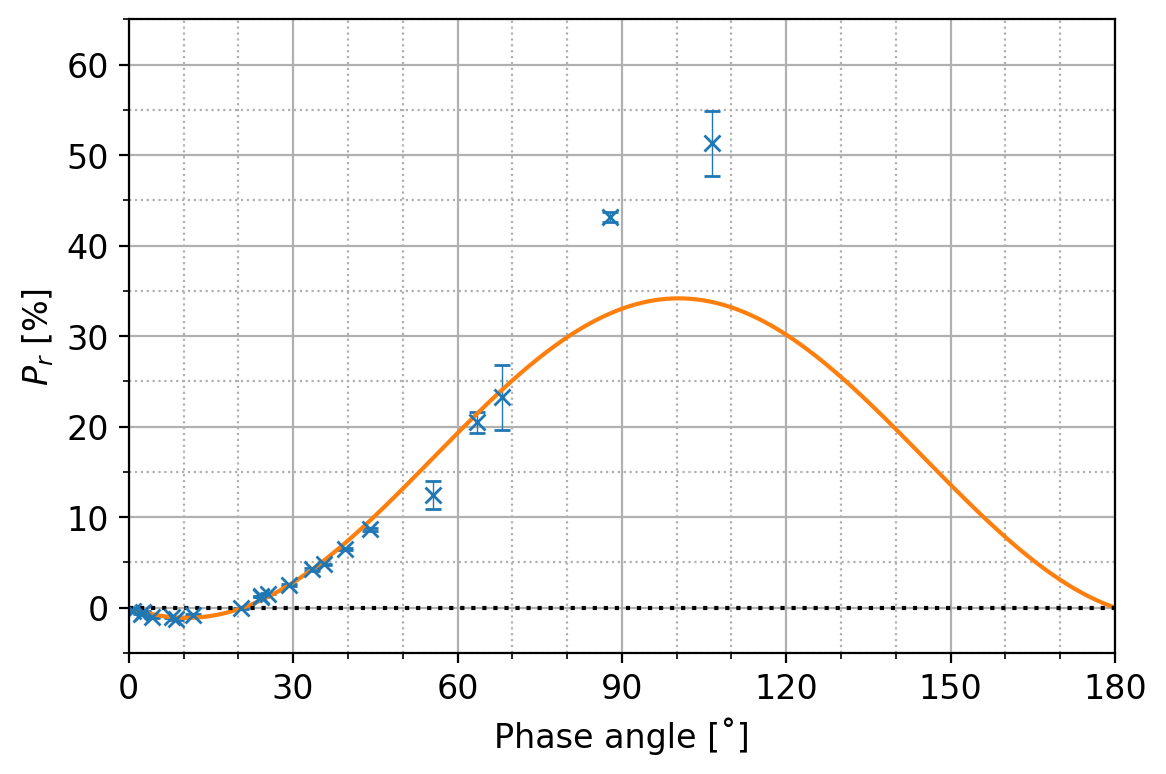

In [6]:
x, y, yerr = dats["alpha"].to_numpy(), dats["Pr"].to_numpy(), dats["dPr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 65)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "observation-fit.png")
plt.savefig(SAVEPATH / "observation-fit.pdf")

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse (which is not used for error analysis):

In [7]:
popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.2165  1.0140  0.0001  20.8573

Elliptical Approximation Errors of above
0.0034  0.0201  0.0931  0.1256

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
10.50     -1.13    100.36 34.18


### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 

**HERE I AM ASSUMING THE POWER PARAMETERS (C1 AND C2) ARE POSITIVE**. For non-bounded case, see section 5.

Run pymc3 for MCMC simulation:

In [8]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', 1.e-4, 3)
    c2 = pm.Uniform('c2', 1.e-4, 3)
#     c2 = pm.HalfNormal('c2', 0.1)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:42<00:00, 1921.28draws/s]
The acceptance probability does not match the target. It is 0.882750646893346, but should be close to 0.8. Try to increase the number of tuning steps.


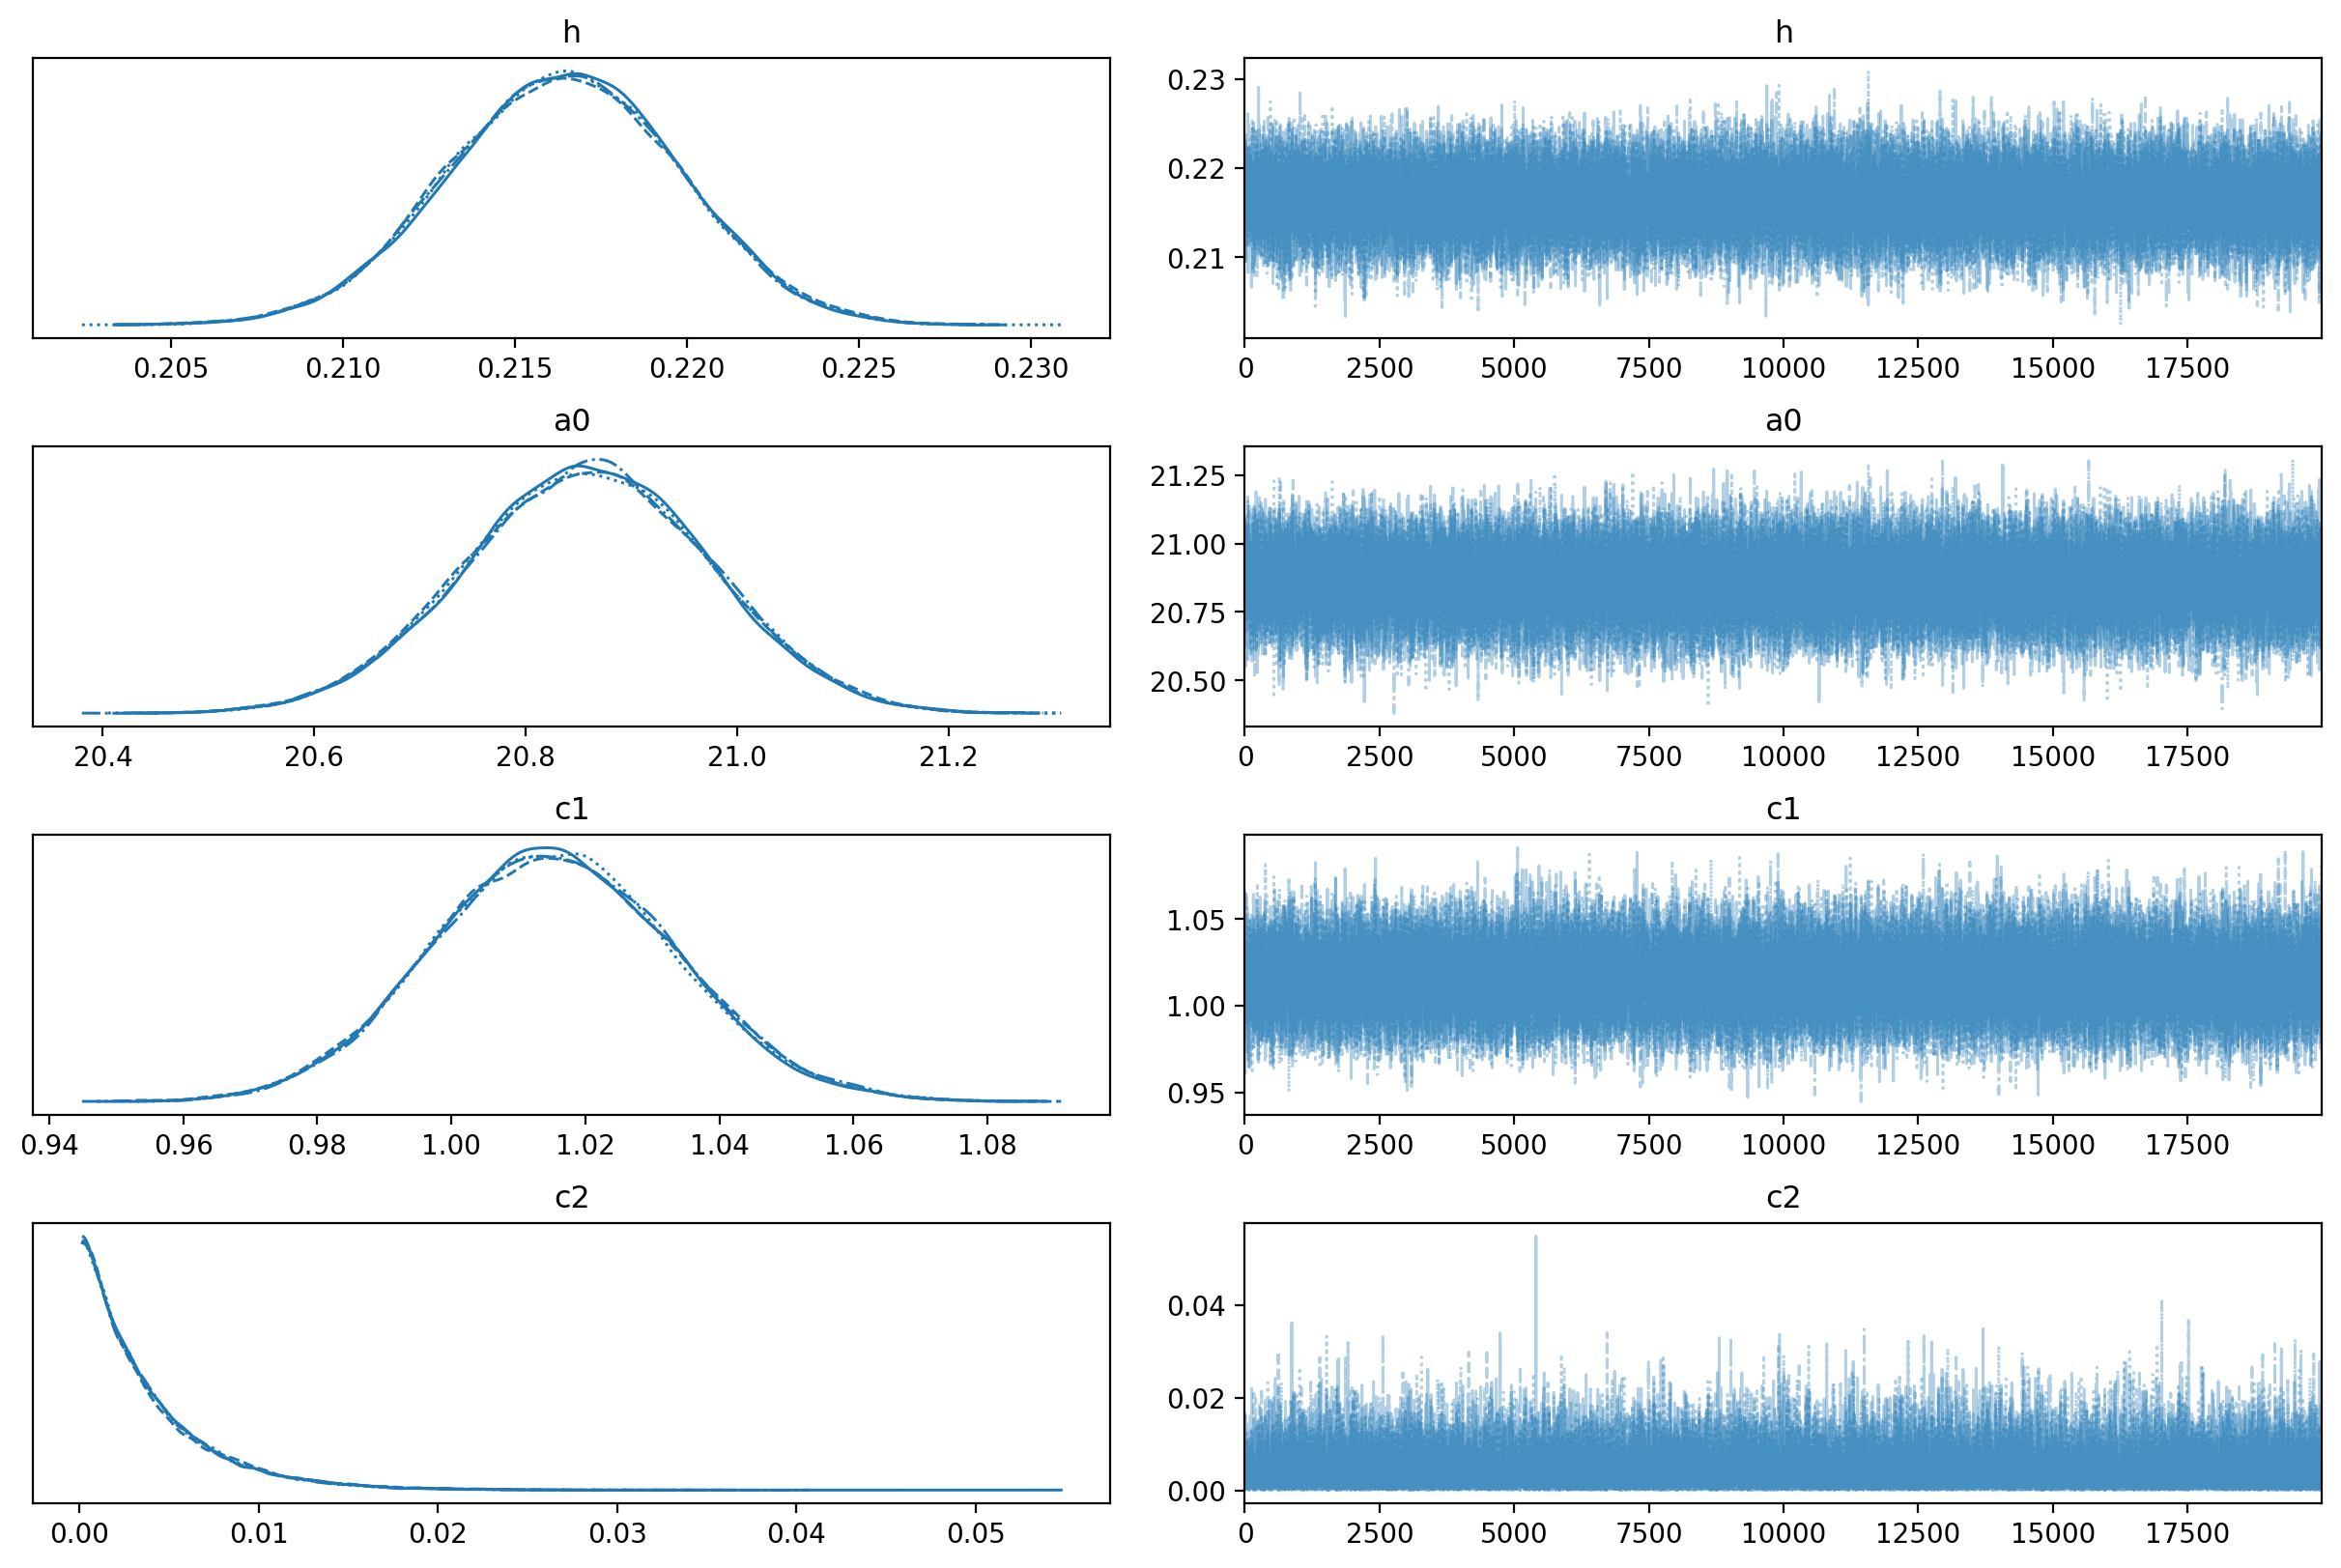

In [9]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace.png", dpi=300)
plt.savefig(SAVEPATH / "trace.pdf")

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [10]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.216  0.003   0.210    0.223      0.000      0.0   33556.0  33556.0   
a0  20.858  0.115  20.640   21.070      0.001      0.0   39044.0  39044.0   
c1   1.015  0.018   0.981    1.049      0.000      0.0   41594.0  41513.0   
c2   0.004  0.004   0.000    0.011      0.000      0.0   70736.0  70307.0   

    ess_bulk  ess_tail  r_hat  
h    33556.0   38174.0    1.0  
a0   39067.0   42992.0    1.0  
c1   41717.0   44934.0    1.0  
c2   46353.0   32059.0    1.0

In summary, $ h = 0.216 \pm 0.003 \,[\%/^\circ] $ etc, for $ \mathrm{mean \pm std} $ notation.

In [11]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.216  0.003   0.210    0.223      0.000      0.0   33556.0  33556.0   
a0  20.858  0.115  20.640   21.070      0.001      0.0   39044.0  39044.0   
c1   1.015  0.018   0.981    1.049      0.000      0.0   41594.0  41513.0   
c2   0.004  0.004   0.000    0.011      0.000      0.0   70736.0  70307.0   

    ess_bulk  ess_tail  r_hat  
h    33556.0   38174.0    1.0  
a0   39067.0   42992.0    1.0  
c1   41717.0   44934.0    1.0  
c2   46353.0   32059.0    1.0

In [12]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 10.5053 ± 0.1179
P_min = -1.1298 ± 0.0303


### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [13]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_a0=res["a0"], arr_c1=res["c1"], arr_c2=res["c2"],
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  43861.000000  43861.000000  43861.000000  43861.000000  43861.000000   
mean       0.216435      1.014694      0.002211     20.857215    720.480363   
std        0.002499      0.013646      0.001732      0.085502      1.149428   
min        0.209430      0.977262      0.000100     20.613637    717.703307   
25%        0.214632      1.004814      0.000817     20.795380    719.580409   
50%        0.216444      1.014574      0.001760     20.857374    720.531793   
75%        0.218250      1.024493      0.003204     20.919413    721.445952   
max        0.223285      1.053178      0.009035     21.088941    722.422861   

               amax          amin          Pmax          Pmin  
count  43861.000000  43861.000000  43861.000000  43861.000000  
mean     100.318237     10.502470     34.162462     -1.130183  
std        0.081232      0.085531      0.328460      0.022629  
min      100.130000     10.260000     33.262541     -1.193055  
25%      100.260000     10.440000     33.923822     -1.146466  
50%      100.320000     10.500000     34.160307     -1.130246  
75%      100.380000     10.560000     34.398942     -1.113738  
max      100.560000     10.740000     35.092757     -1.066783

Only the rows of ``min`` and ``max`` are important (see below). Others are virtually meaningless.

Below is shown for the chi-square result for alpha_min/max and P_min/max

In [14]:
res_df.describe()

h            c1            c2            a0          chi2  \
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000   
mean       0.216406      1.015249      0.003899     20.857937    722.715799   
std        0.003352      0.018277      0.003789      0.114655      3.177045   
min        0.202381      0.944754      0.000100     20.379364    717.703307   
25%        0.214133      1.002739      0.001183     20.780308    720.374891   
50%        0.216434      1.015002      0.002734     20.858510    722.062394   
75%        0.218696      1.027536      0.005383     20.936335    724.369227   
max        0.230904      1.091111      0.054820     21.307056    751.167473   

               amax         amin          Pmax          Pmin  
count  80000.000000  80000.00000  80000.000000  80000.000000  
mean     100.288436     10.50520     34.150664     -1.129826  
std        0.119958      0.11434      0.439156      0.030337  
min       99.290000     10.01000     32.300873     -1.253043  
25%      100.210000     10.43000     33.852662     -1.150362  
50%      100.290000     10.51000     34.149406     -1.129973  
75%      100.370000     10.58000     34.446088     -1.109193  
max      100.750000     10.99000     36.116170     -1.006529

Summarize:

In [15]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs      plus         minus        mins        maxs
0     h    0.216487  0.006798  7.056512e-03    0.209430    0.223285
1    c1    1.014002  0.039176  3.673989e-02    0.977262    1.053178
2    c2    0.000100  0.008935  1.570636e-07    0.000100    0.009035
3    a0   20.857317  0.231625  2.436799e-01   20.613637   21.088941
4  amin   10.500000  0.240000  2.400000e-01   10.260000   10.740000
5  Pmin   -1.130760  0.063977  6.229497e-02   -1.193055   -1.066783
6  amax  100.360000  0.200000  2.300000e-01  100.130000  100.560000
7  Pmax   34.177919  0.914838  9.153778e-01   33.262541   35.092757

That is, for example, $h = 0.2165 ^{+0.0068}_{-0.0071} \,[\%/^\circ] $ such that the min/max are 0.2094 and 0.2233. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-4. Some Selected Model Plots from MCMC
Among the 80000 samples (excluding the first 2000 as burn-in phase, so that, e.g., ``len(trace.get_values['h'])`` will be 80000 not 82000), I plotted the models at every 100 index interval as black dotted line below. They're not necessarily "good" models because they are nothing but "trace".

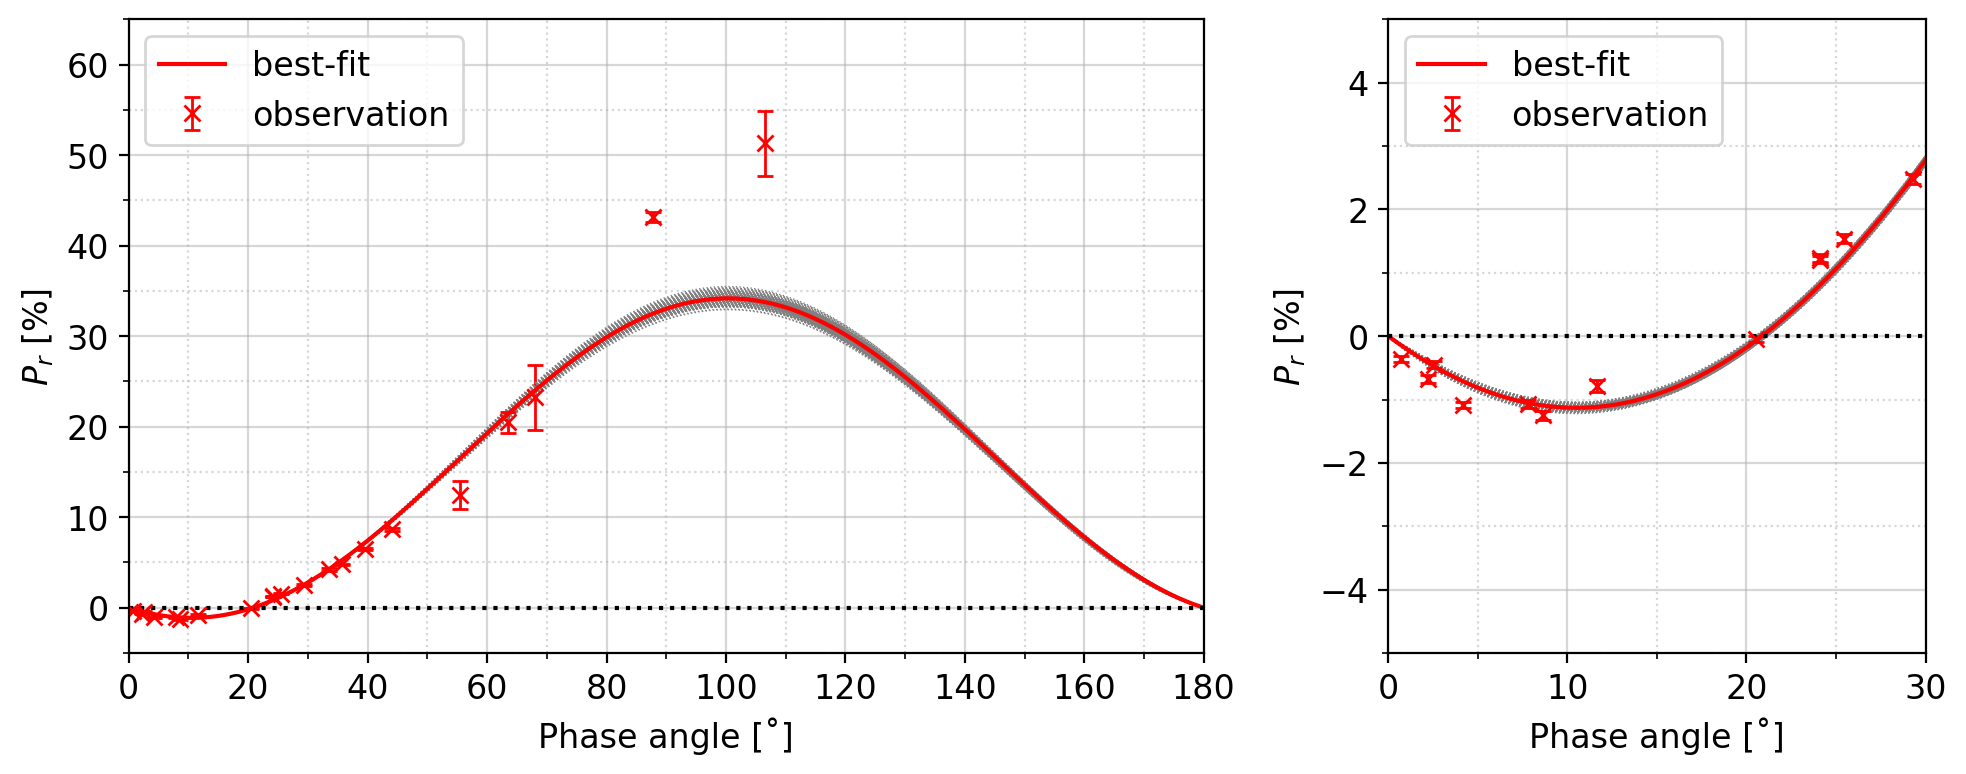

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

yvu.linticker(axs, xmajlockws=[20, 10], xminlockws=[10, 5], ymajlockws=[10, 2], yminlockws=[5, 1])
axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 65)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)

plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc.pdf")

### 4-5. Pairplot of Parameters

Draw a corner plot

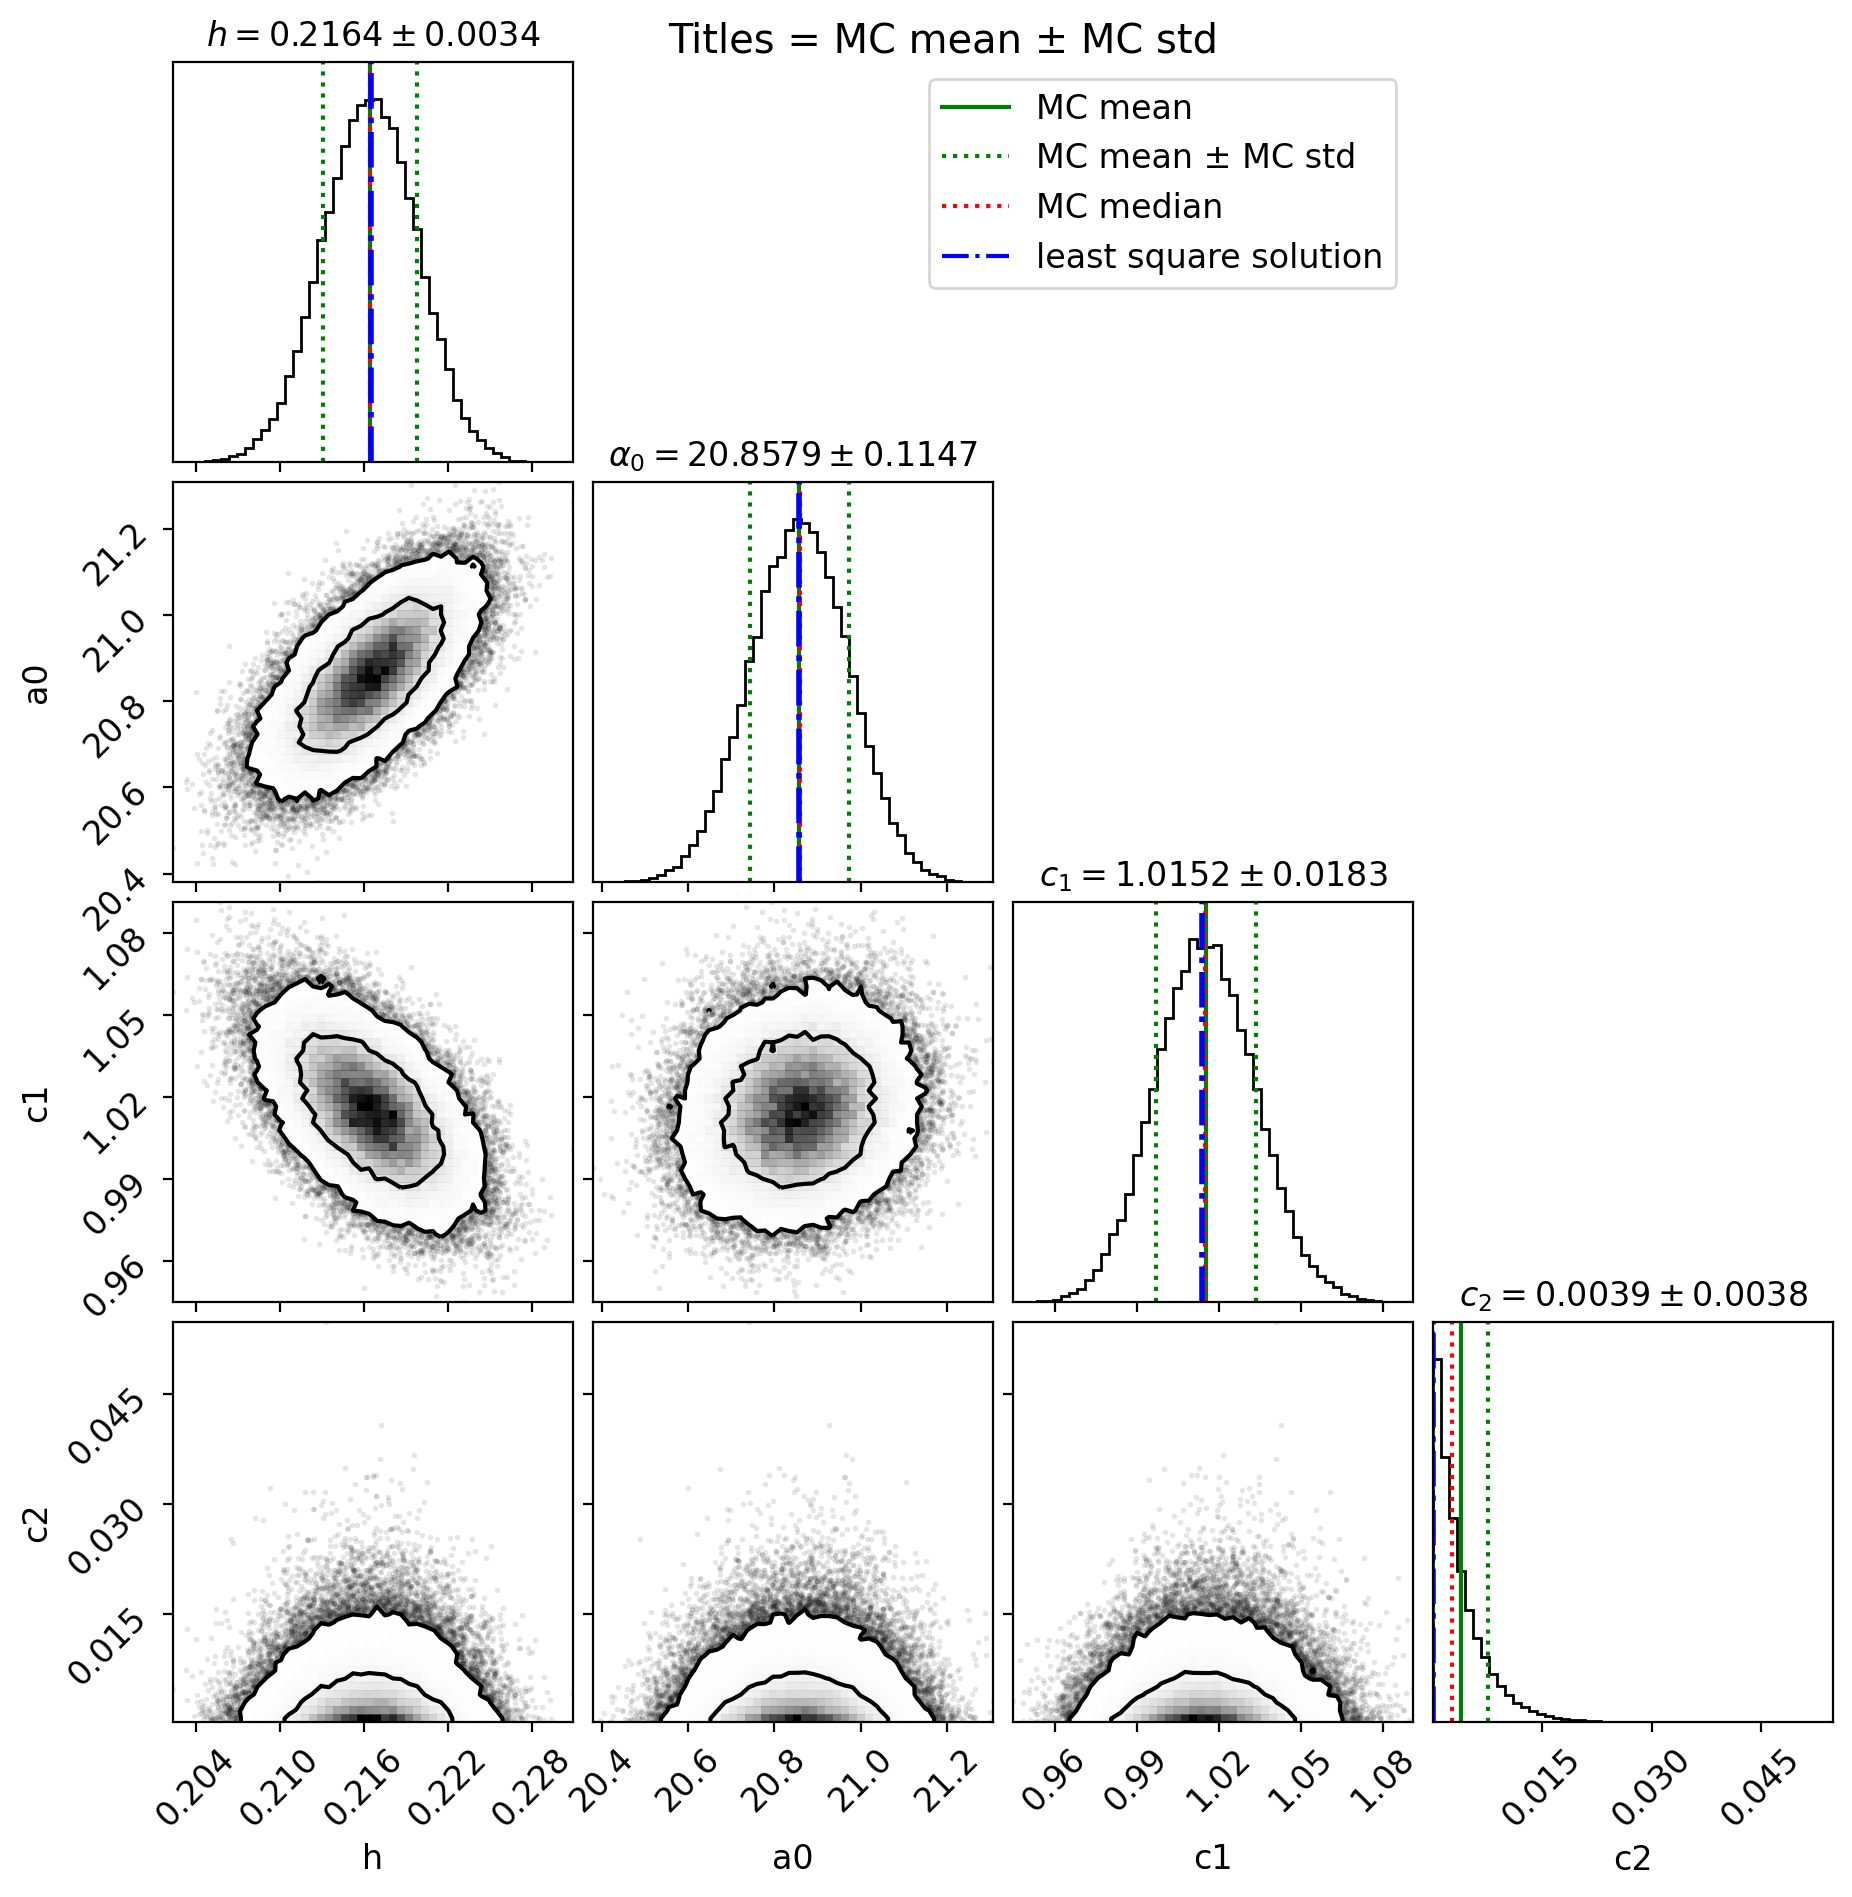

In [17]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(trace_df, 
#                     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=False,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[4+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"corner.pdf")
plt.savefig(SAVEPATH/"corner.png", dpi=300);

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [18]:
from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

tab = Table.from_pandas(param_tab)

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tab.write(SAVEPATH / "test.tex", format='ascii.latex', latexdict=latexdicts["AA"])

``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

It has the following output:

```latex
\begin{table}
\begin{tabular}{cccccc}
\hline \hline
pars & lsqs & plus & minus & mins & maxs \\
\hline
h & 0.2082 & 0.0178 & 0.0157 & 0.1925 & 0.2261 \\
c1 & 0.8647 & 0.1625 & 0.1120 & 0.7527 & 1.0273 \\
c2 & 0.0001 & 1.2607 & 0.0000 & 0.0001 & 1.2608 \\
a0 & 20.1849 & 0.6554 & 0.6485 & 19.5364 & 20.8404 \\
amin & 9.3800 & 1.0600 & 0.9000 & 8.4800 & 10.4400 \\
Pmin & -1.1692 & 0.1446 & 0.1485 & -1.3176 & -1.0246 \\
amax & 100.8100 & 0.5500 & 16.0500 & 84.7600 & 101.3600 \\
Pmax & 29.0842 & 3.4382 & 7.5246 & 21.5596 & 32.5224 \\
\hline
\end{tabular}
\end{table}
```

You may tune it as you wish...

## 5. What if no bound for powers?

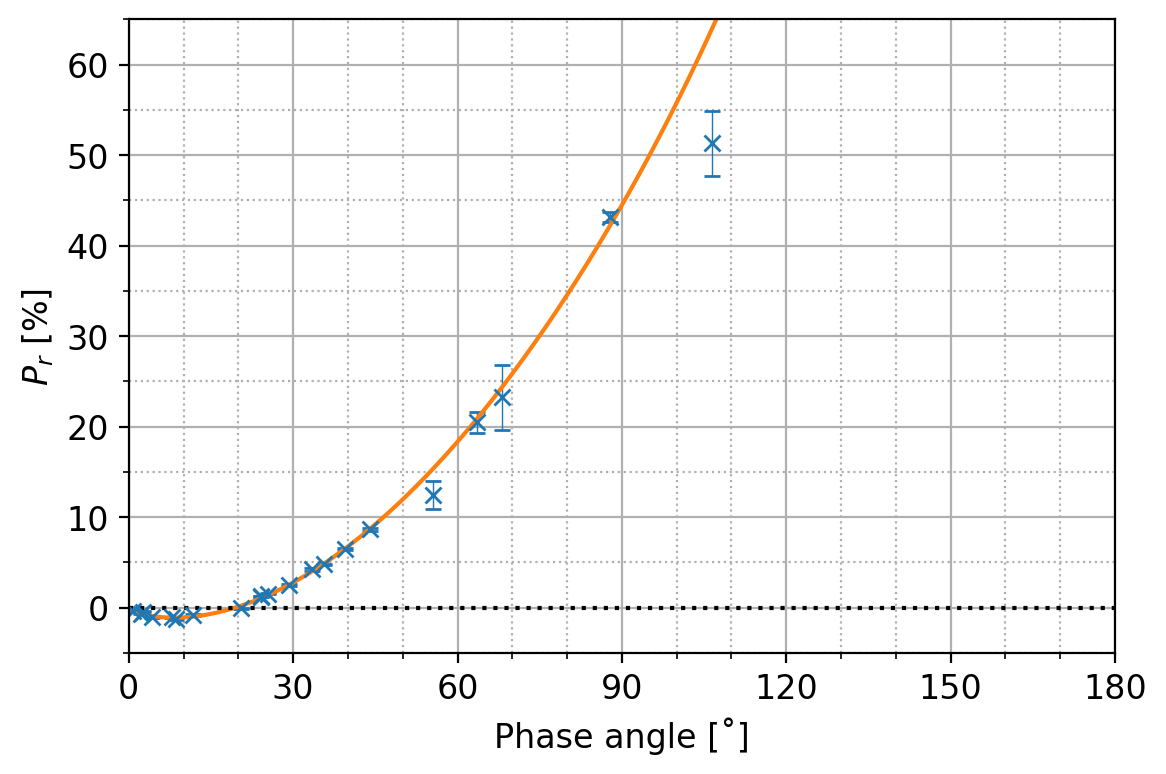

In [19]:
x, y, yerr = dats["alpha"].to_numpy(), dats["Pr"].to_numpy(), dats["dPr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 65)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "observation-fit-nobound.png")
plt.savefig(SAVEPATH / "observation-fit-nobound.pdf")

In [20]:
x, y, yerr = dats["alpha"].to_numpy(), dats["Pr"].to_numpy(), dats["dPr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))
print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.1887  0.7284  -2.0218  19.4360

Elliptical Approximation Errors of above
0.0029  0.0164  0.0780  0.1437

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
8.29     -1.11    129.98 102.94


In [21]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', -10, 10)
    c2 = pm.Uniform('c2', -10, 10)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:47<00:00, 1735.69draws/s]
The acceptance probability does not match the target. It is 0.8912837247047983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883149571482295, but should be close to 0.8. Try to increase the number of tuning steps.


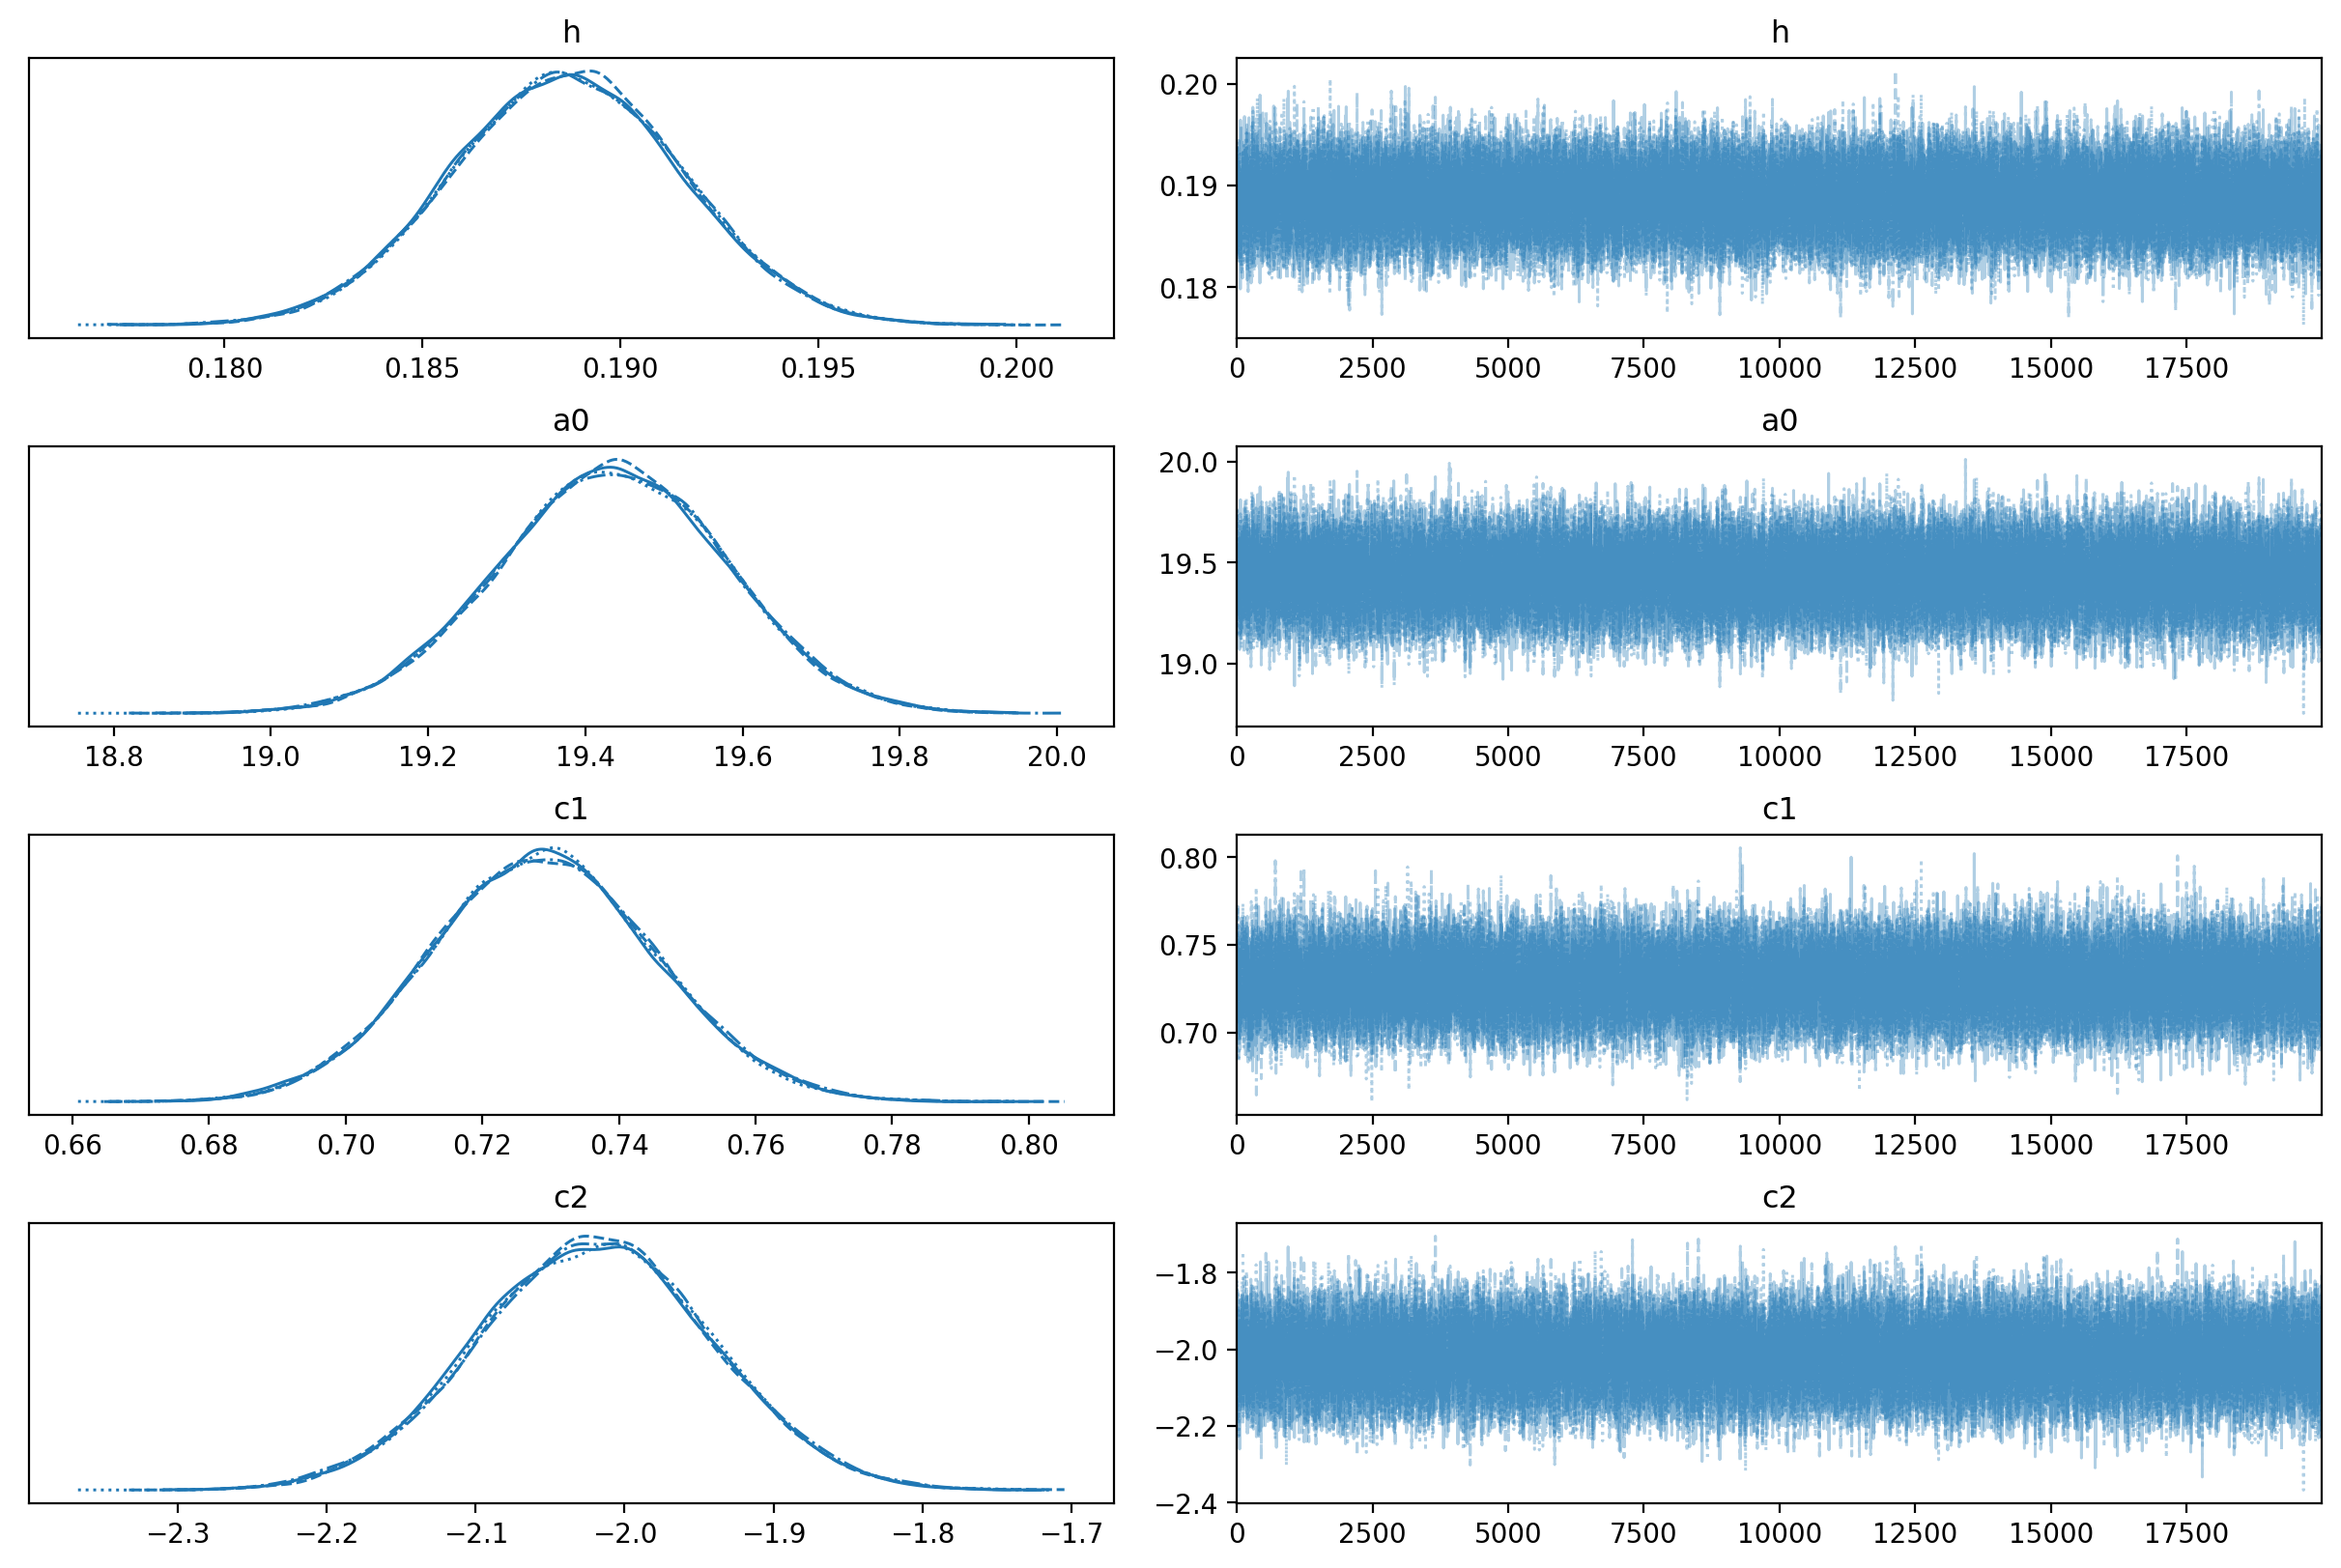

In [22]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "trace-nobound.pdf")

In [23]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.189  0.003   0.183    0.194      0.000    0.000   29799.0  29799.0   
a0  19.434  0.145  19.158   19.701      0.001    0.001   27684.0  27684.0   
c1   0.729  0.016   0.698    0.760      0.000    0.000   29963.0  29936.0   
c2  -2.020  0.078  -2.168   -1.875      0.000    0.000   27779.0  27779.0   

    ess_bulk  ess_tail  r_hat  
h    29798.0   39924.0    1.0  
a0   27693.0   37933.0    1.0  
c1   29986.0   37421.0    1.0  
c2   27770.0   36788.0    1.0

In [24]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.189  0.003   0.183    0.194      0.000    0.000   29799.0  29799.0   
a0  19.434  0.145  19.158   19.701      0.001    0.001   27684.0  27684.0   
c1   0.729  0.016   0.698    0.760      0.000    0.000   29963.0  29936.0   
c2  -2.020  0.078  -2.168   -1.875      0.000    0.000   27779.0  27779.0   

    ess_bulk  ess_tail  r_hat  
h    29798.0   39924.0    1.0  
a0   27693.0   37933.0    1.0  
c1   29986.0   37421.0    1.0  
c2   27770.0   36788.0    1.0

In [25]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 8.2881 ± 0.1467
P_min = -1.1091 ± 0.0256


In [26]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  54005.000000  54005.000000  54005.000000  54005.000000  54005.000000   
mean       0.188692      0.728686     -2.020629     19.435456    127.311075   
std        0.002268      0.012761      0.060645      0.113212      1.200667   
min        0.182587      0.694405     -2.186742     19.126428    124.844606   
25%        0.187049      0.719413     -2.064958     19.354080    126.332194   
50%        0.188687      0.728661     -2.020410     19.435711    127.279973   
75%        0.190328      0.737800     -1.976901     19.517755    128.290087   
max        0.194916      0.763493     -1.858141     19.739726    129.563932   

               amax          amin          Pmax          Pmin  
count  5.400500e+04  54005.000000  54005.000000  54005.000000  
mean   1.399800e+02      8.288228    127.823870     -1.109505  
std    1.894609e-10      0.111774      6.970144      0.019953  
min    1.399800e+02      7.990000    110.114932     -1.163467  
25%    1.399800e+02      8.210000    122.683956     -1.123925  
50%    1.399800e+02      8.290000    127.604020     -1.109488  
75%    1.399800e+02      8.370000    132.812591     -1.095091  
max    1.399800e+02      8.590000    148.129284     -1.055937

In [27]:
res_df.describe()

h            c1            c2            a0          chi2  \
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000   
mean       0.188651      0.728854     -2.020150     19.433676    128.901552   
std        0.002906      0.016457      0.078004      0.144936      2.874083   
min        0.176277      0.660668     -2.367386     18.753609    124.844606   
25%        0.186677      0.717677     -2.073365     19.336755    126.787172   
50%        0.188646      0.728738     -2.020055     19.434697    128.248604   
75%        0.190623      0.739813     -1.967507     19.532472    130.312818   
max        0.201239      0.805372     -1.704211     20.010516    151.955542   

               amax          amin          Pmax          Pmin  
count  8.000000e+04  80000.000000  80000.000000  80000.000000  
mean   1.399800e+02      8.288242    127.869131     -1.109119  
std    2.731343e-10      0.143778      8.971543      0.025577  
min    1.399800e+02      7.700000     95.814258     -1.210937  
25%    1.399800e+02      8.190000    121.654824     -1.126504  
50%    1.399800e+02      8.290000    127.558941     -1.109075  
75%    1.399800e+02      8.390000    133.772099     -1.091716  
max    1.399800e+02      8.950000    170.959749     -0.995598

In [28]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs       plus      minus        mins        maxs
0     h    0.188723   0.006193   0.006137    0.182587    0.194916
1    c1    0.728386   0.035107   0.033981    0.694405    0.763493
2    c2   -2.021790   0.163648   0.164952   -2.186742   -1.858141
3    a0   19.435993   0.303733   0.309565   19.126428   19.739726
4  amin    8.290000   0.300000   0.300000    7.990000    8.590000
5  Pmin   -1.109827   0.053890   0.053640   -1.163467   -1.055937
6  amax  129.980000  10.000000  10.000000  139.980000  139.980000
7  Pmax  102.943466  45.185818   7.171466  110.114932  148.129284

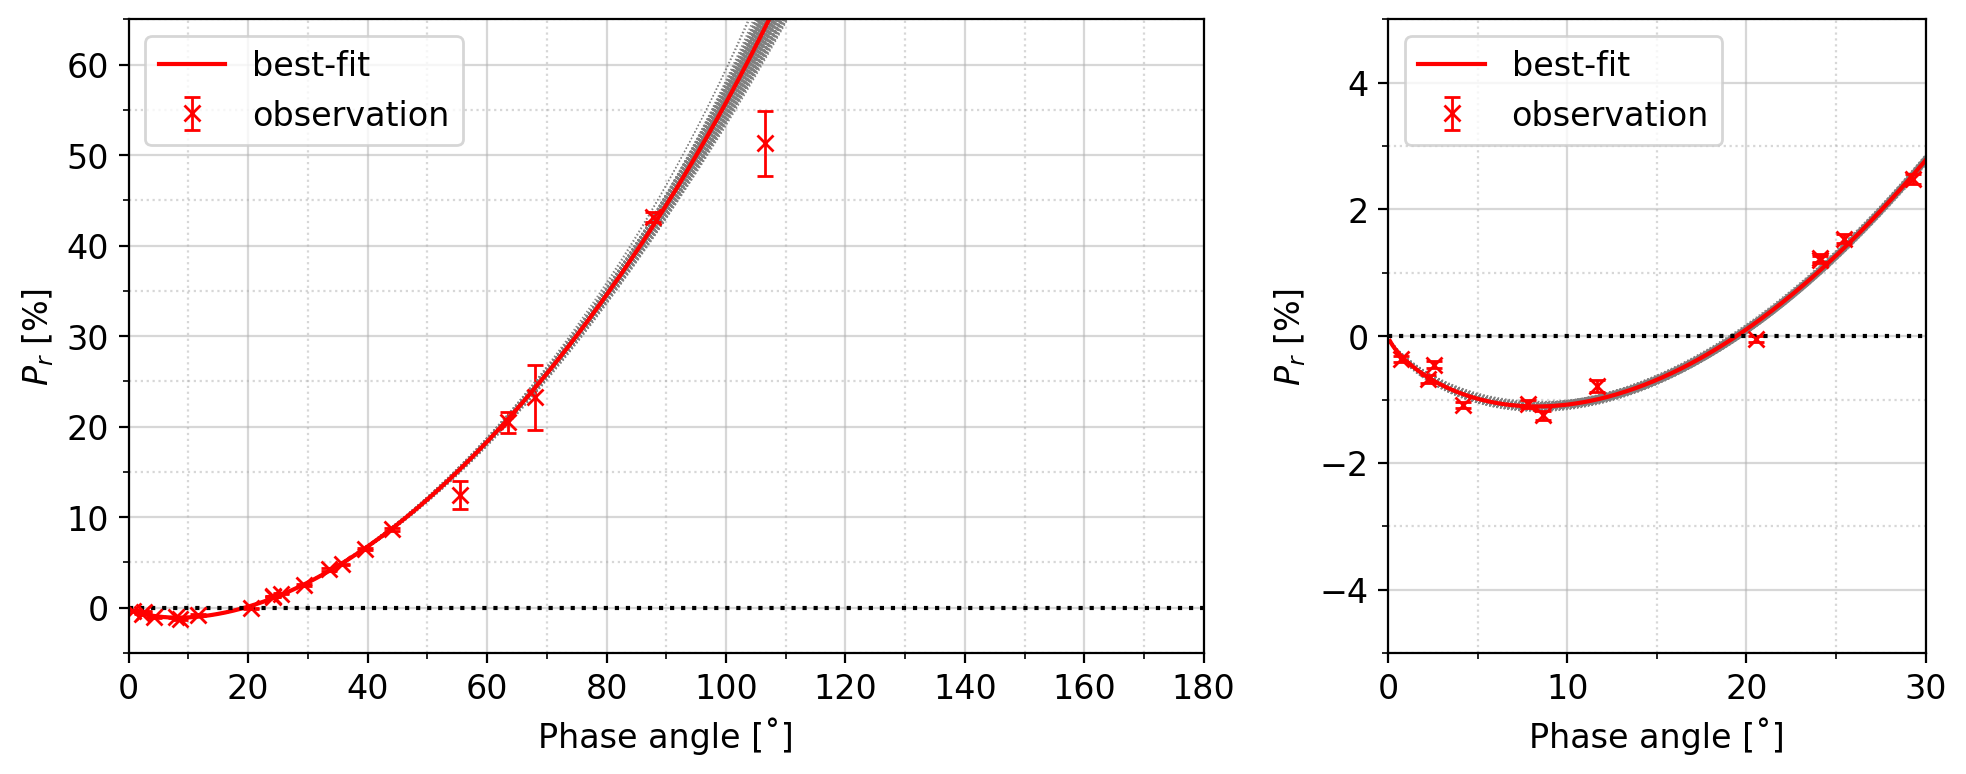

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

yvu.linticker(axs, xmajlockws=[20, 10], xminlockws=[10, 5], ymajlockws=[10, 2], yminlockws=[5, 1])
axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 65)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)

plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc-nobound.pdf")

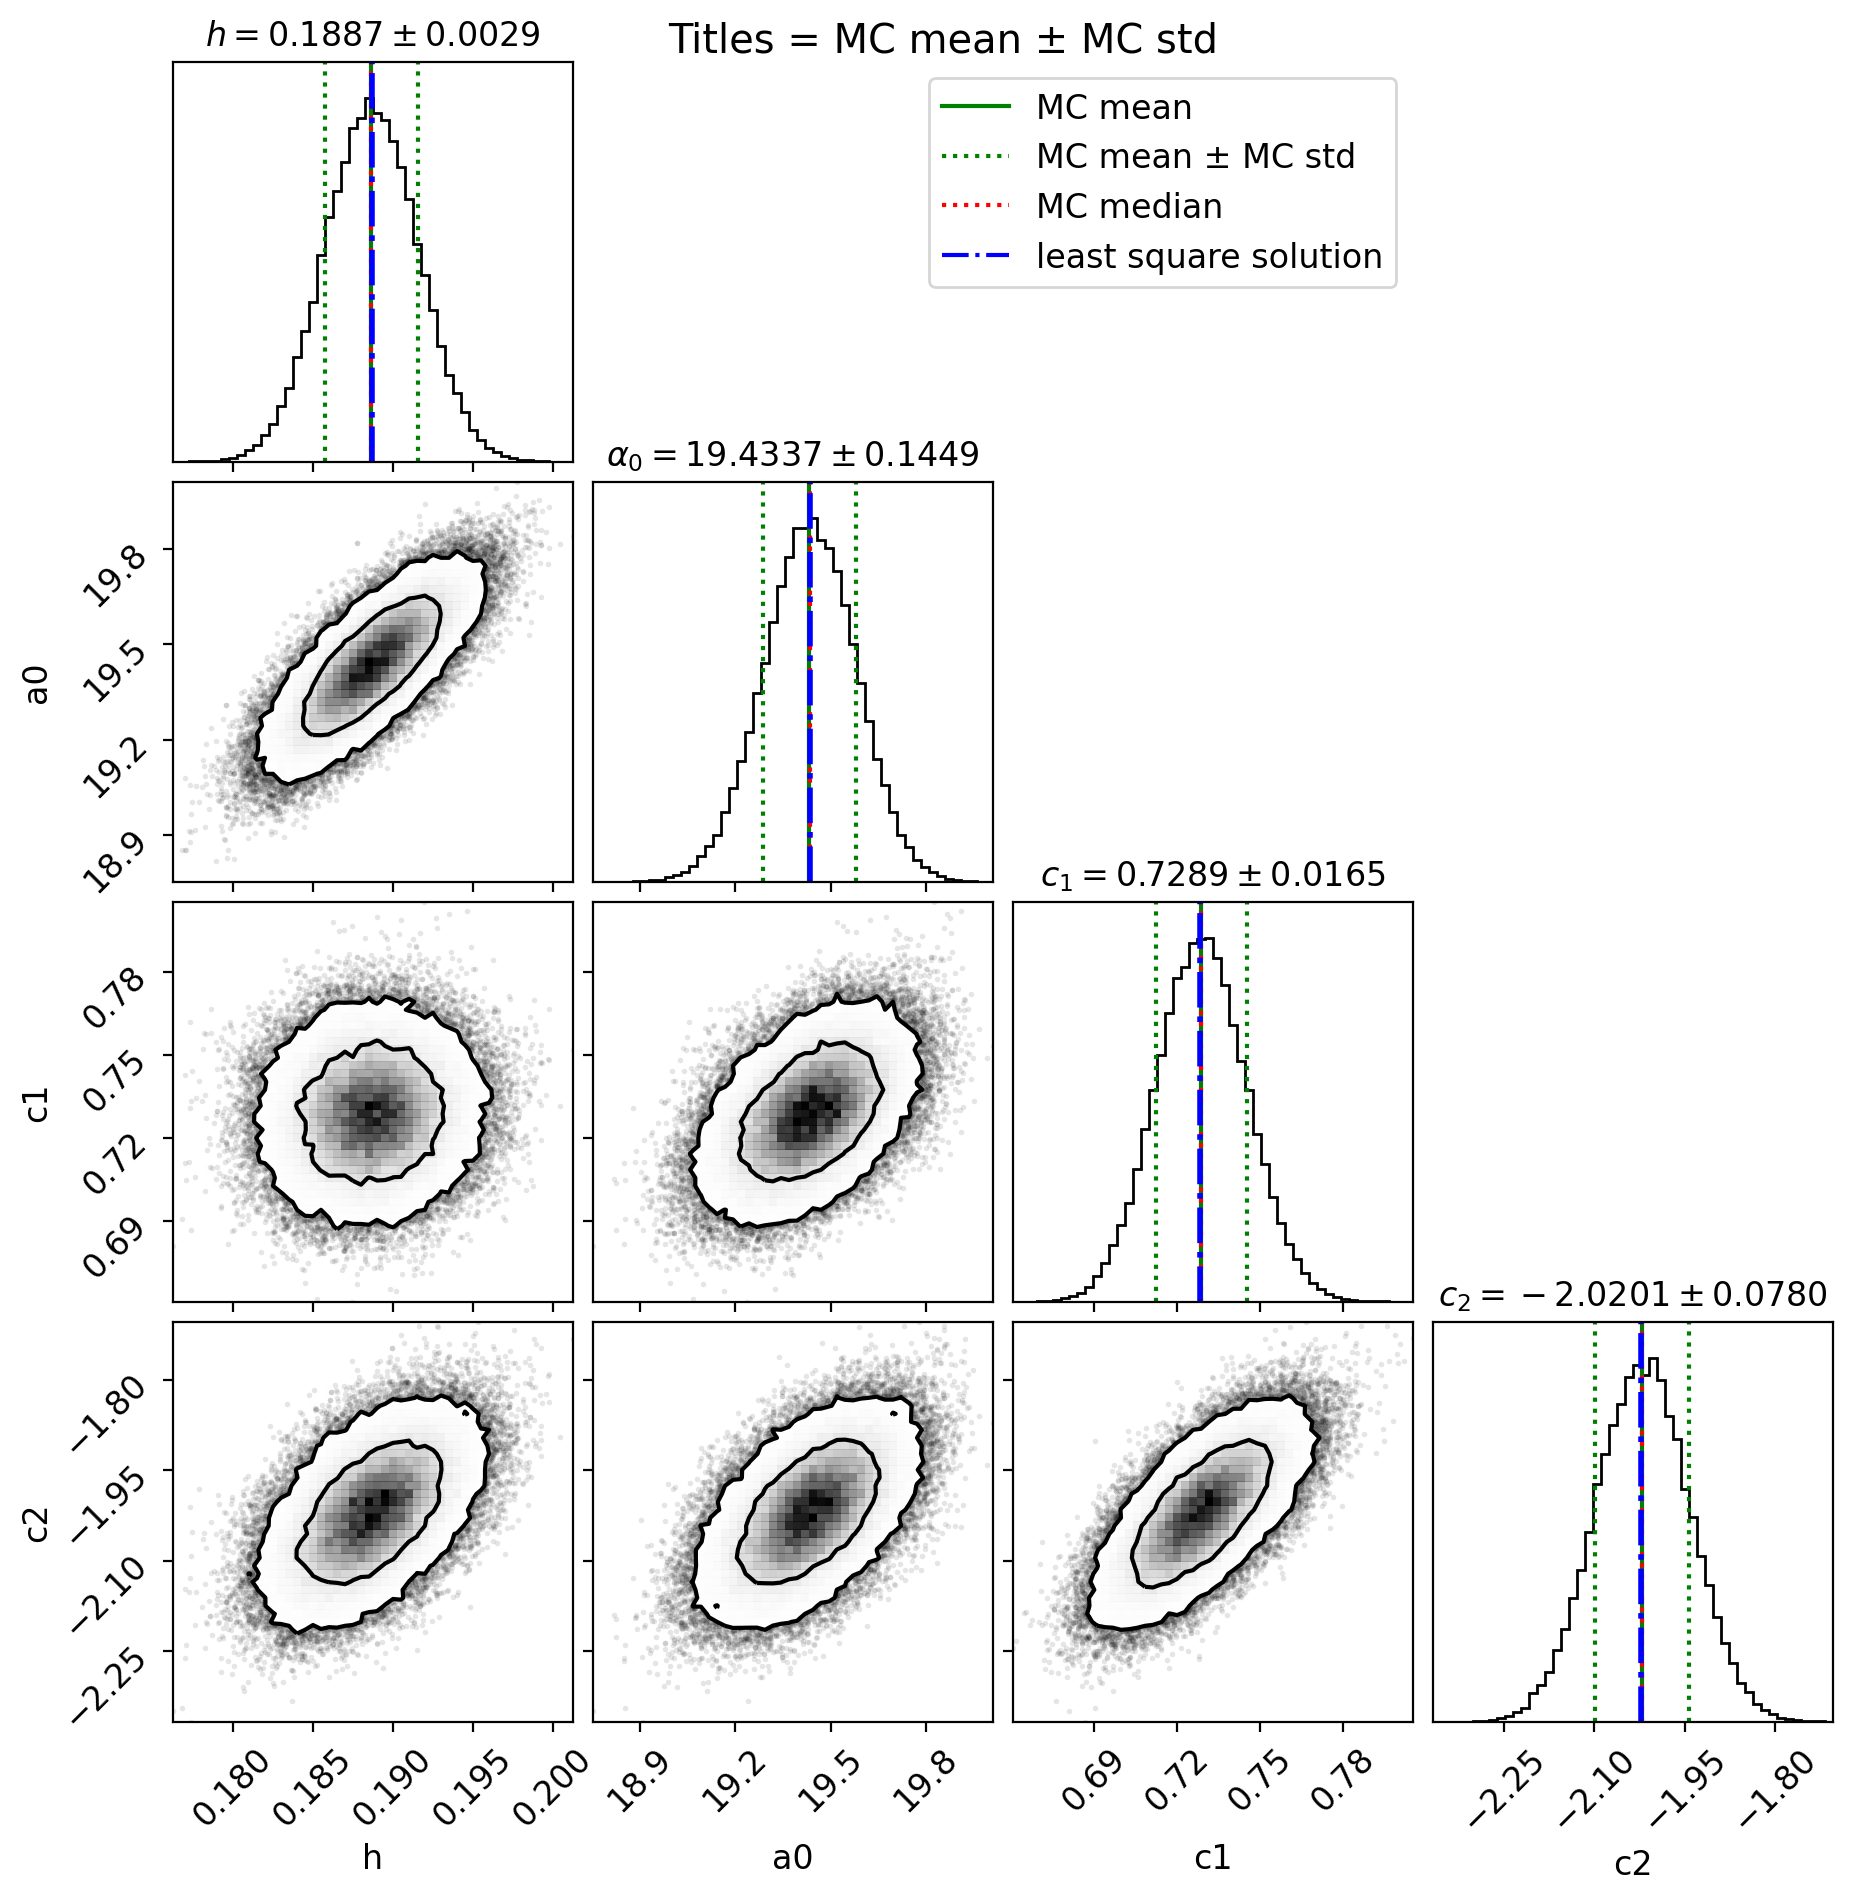

In [30]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(trace_df, 
#                     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=False,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[4+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"corner-nobound.pdf")
plt.savefig(SAVEPATH/"corner-nobound.png", dpi=300)

In [31]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

This notebook was finished at 2021-03-18 20:36:53 (KST = GMT+0900) 
